# Van Der Pol Oscillator with Function Encoders

The Van Der Pol oscillator is a nonlinear dynamical system with rich behavior depending on a parameter $\mu$:

$$\begin{aligned}
\frac{dx}{dt} &= y \\
\frac{dy}{dt} &= \mu(1 - x^2)y - x
\end{aligned}$$

Our goal: learn a neural ODE that can **zero-shot transfer** across different $\mu$ values using function encoders.

**Notebook:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/07-neural-ode/vanderpol-function-encoder.ipynb)

---

## Function Encoder Approach

Rather than learning a single neural ODE, we learn:
1. **Basis functions** $\{g_1, ..., g_k\}$ (neural networks)
2. **Coefficient encoder** that maps $\mu \to$ coefficients $\alpha$

The dynamics are approximated as:
$$f(x; \mu) \approx \sum_{i=1}^k \alpha_i(\mu) g_i(x)$$

### Computing Coefficients via Least Squares

Given trajectory data from a system with parameter $\mu$, we compute coefficients by solving:

$$\alpha = \arg\min_\alpha \sum_{t=1}^T \left\| \Delta x_t - \sum_{i=1}^k \alpha_i g_i(x_t) \Delta t \right\|^2$$

This has closed-form solution: $\alpha = (G^T G)^{-1} G^T F$

where $G_{ti} = g_i(x_t) \Delta t$ and $F_t = \Delta x_t$.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

torch.manual_seed(42)
np.random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


## Van Der Pol Dynamics

We implement RK4 integration for accurate numerical simulation.

In [2]:
def rk4_step(f, x, dt):
    """Single RK4 integration step"""
    k1 = f(x)
    k2 = f(x + 0.5 * dt * k1)
    k3 = f(x + 0.5 * dt * k2)
    k4 = f(x + dt * k3)
    return x + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

def vanderpol_dynamics(mu):
    """Returns Van Der Pol dynamics function for given mu"""
    def f(x):
        # x has shape [..., 2] where x[..., 0] = x, x[..., 1] = y
        dx = x[..., 1:2]
        dy = mu * (1 - x[..., 0:1]**2) * x[..., 1:2] - x[..., 0:1]
        return torch.cat([dx, dy], dim=-1)
    return f

def generate_trajectory(mu, x0, t_span, n_points=100):
    """Generate trajectory for Van Der Pol oscillator"""
    t = torch.linspace(t_span[0], t_span[1], n_points).to(device)
    xs = torch.zeros(n_points, 2).to(device)
    xs[0] = x0
    
    f = vanderpol_dynamics(mu)
    for i in range(n_points - 1):
        dt = t[i+1] - t[i]
        xs[i+1] = rk4_step(f, xs[i], dt)
    
    return t, xs

## Visualize Van Der Pol Dynamics

Let's see how the dynamics change with $\mu$:

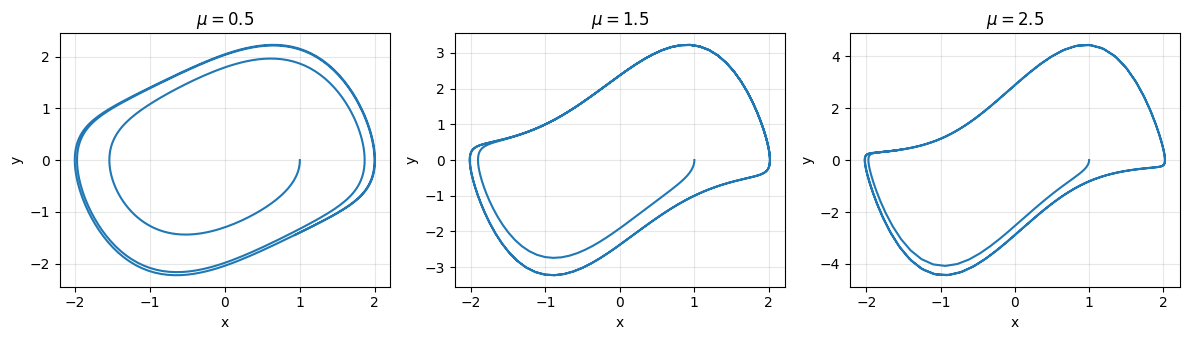

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
mus_test = [0.5, 1.5, 2.5]
x0 = torch.tensor([1.0, 0.0]).to(device)

for i, mu in enumerate(mus_test):
    t, xs = generate_trajectory(mu, x0, [0, 20], n_points=500)
    xs_np = xs.cpu().numpy()
    axes[i].plot(xs_np[:, 0], xs_np[:, 1], linewidth=1.5)
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_title(f'$\\mu = {mu}$')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/vanderpol_phase_portraits.png', dpi=150, bbox_inches='tight')
plt.show()

## Function Encoder: Basis Functions

We learn $k$ basis functions, each a small neural network $g_i: \mathbb{R}^2 \to \mathbb{R}^2$.

In [4]:
class BasisFunction(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, x):
        return self.net(x)

# Create k=8 basis functions
k = 8
basis_functions = [BasisFunction().to(device) for _ in range(k)]
print(f"Created {k} basis functions")

Created 8 basis functions


## Computing Coefficients: Least Squares Solution

For a trajectory $(x_1, ..., x_T)$ from a system with parameter $\mu$, we solve:

$$\min_\alpha \sum_{t=1}^{T-1} \left\| (x_{t+1} - x_t) - \sum_{i=1}^k \alpha_i \cdot g_i(x_t) \Delta t \right\|^2$$

Closed form: $\alpha = (G^T G)^{-1} G^T F$ where:
- $F \in \mathbb{R}^{(T-1) \times 2}$: true state changes
- $G \in \mathbb{R}^{(T-1) \times 2 \times k}$: basis function evaluations

In [5]:
def compute_coefficients_ls(basis_fns, trajectory, time_diffs):
    """
    Compute coefficients via least squares
    Args:
        basis_fns: list of k basis functions
        trajectory: (T, 2) trajectory data
        time_diffs: (T-1,) time differences
    Returns:
        coefficients: (2, k) coefficient matrix
    """
    T = len(trajectory)
    k = len(basis_fns)
    
    # F: true state changes (T-1, 2)
    F = trajectory[1:] - trajectory[:-1]
    
    # G: basis evaluations (T-1, 2, k)
    G = torch.zeros(T-1, 2, k).to(device)
    for i, basis_fn in enumerate(basis_fns):
        # Evaluate basis function at each point
        delta = basis_fn(trajectory[:-1])  # (T-1, 2)
        # Scale by time differences
        G[:, :, i] = delta * time_diffs.unsqueeze(-1)
    
    # Solve least squares for each output dimension
    coeffs = torch.zeros(2, k).to(device)
    for dim in range(2):
        G_dim = G[:, dim, :]  # (T-1, k)
        F_dim = F[:, dim]      # (T-1,)
        
        # Solve: alpha = (G^T G)^{-1} G^T F
        GTG = G_dim.T @ G_dim  # (k, k)
        GTF = G_dim.T @ F_dim  # (k,)
        
        # Add regularization for stability
        GTG_reg = GTG + 1e-6 * torch.eye(k).to(device)
        coeffs[dim] = torch.linalg.solve(GTG_reg, GTF)
    
    return coeffs

# Test coefficient computation
mu_test = 1.0
t, xs = generate_trajectory(mu_test, torch.tensor([1.0, 0.0]).to(device), [0, 10], n_points=200)
dt = t[1:] - t[:-1]

with torch.no_grad():
    coeffs = compute_coefficients_ls(basis_functions, xs, dt)
    print(f"Coefficient matrix shape: {coeffs.shape}")
    print(f"Coefficient norm: {torch.norm(coeffs):.3f}")

Coefficient matrix shape: torch.Size([2, 8])
Coefficient norm: 62.018


## Training: Learn Basis Functions

We train basis functions on multiple Van Der Pol systems with different $\mu$ values.

**Training objective**: Minimize reconstruction error across all systems:
$$\mathcal{L} = \sum_{\mu \in \text{train}} \sum_{t=1}^{T-1} \left\| (x_{t+1} - x_t) - \sum_{i=1}^k \alpha_i(\mu) \cdot g_i(x_t) \Delta t \right\|^2$$

where $\alpha(\mu)$ are computed via least squares for each $\mu$.

In [6]:
# Training parameters
n_train_systems = 5
mu_range = [0.5, 2.5]
mus_train = torch.linspace(mu_range[0], mu_range[1], n_train_systems)
n_epochs = 3000
lr = 1e-3

print(f"Training on {n_train_systems} systems: mu = {mus_train.numpy()}")

# Optimizer for all basis functions
params = []
for basis_fn in basis_functions:
    params.extend(list(basis_fn.parameters()))
optimizer = torch.optim.Adam(params, lr=lr)

# Generate training trajectories
train_trajectories = []
train_times = []
for mu in mus_train:
    x0 = torch.tensor([np.random.uniform(-1, 1), np.random.uniform(-1, 1)]).to(device)
    t, xs = generate_trajectory(mu, x0, [0, 15], n_points=300)
    train_trajectories.append(xs)
    train_times.append(t)

print("\nTraining basis functions...")
losses = []

for epoch in trange(n_epochs):
    optimizer.zero_grad()
    total_loss = 0
    
    for xs, t in zip(train_trajectories, train_times):
        dt = t[1:] - t[:-1]
        
        # Compute coefficients via least squares
        coeffs = compute_coefficients_ls(basis_functions, xs, dt)
        
        # Reconstruct dynamics
        F_true = xs[1:] - xs[:-1]  # (T-1, 2)
        
        # Compute predicted changes
        F_pred = torch.zeros_like(F_true)
        for i, basis_fn in enumerate(basis_functions):
            delta = basis_fn(xs[:-1])  # (T-1, 2)
            F_pred += coeffs[:, i] * delta * dt.unsqueeze(-1)
        
        # MSE loss
        loss = torch.mean((F_true - F_pred)**2)
        total_loss += loss
    
    total_loss.backward()
    optimizer.step()
    losses.append(total_loss.item())
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: loss={total_loss.item():.6f}")

print(f"\nFinal loss: {losses[-1]:.6f}")

Training on 5 systems: mu = [0.5 1.  1.5 2.  2.5]

Training basis functions...


  0%|          | 4/3000 [00:00<01:18, 38.04it/s]

Epoch 0: loss=0.007081


 17%|█▋        | 509/3000 [00:10<00:52, 47.26it/s]

Epoch 500: loss=0.000005


 34%|███▎      | 1009/3000 [00:21<00:42, 47.02it/s]

Epoch 1000: loss=0.000002


 50%|█████     | 1509/3000 [00:32<00:32, 45.78it/s]

Epoch 1500: loss=0.000001


 67%|██████▋   | 2009/3000 [00:42<00:21, 47.12it/s]

Epoch 2000: loss=0.000001


 84%|████████▎ | 2509/3000 [00:53<00:10, 47.94it/s]

Epoch 2500: loss=0.000001


100%|██████████| 3000/3000 [01:04<00:00, 46.83it/s]


Final loss: 0.000002


## Training Loss

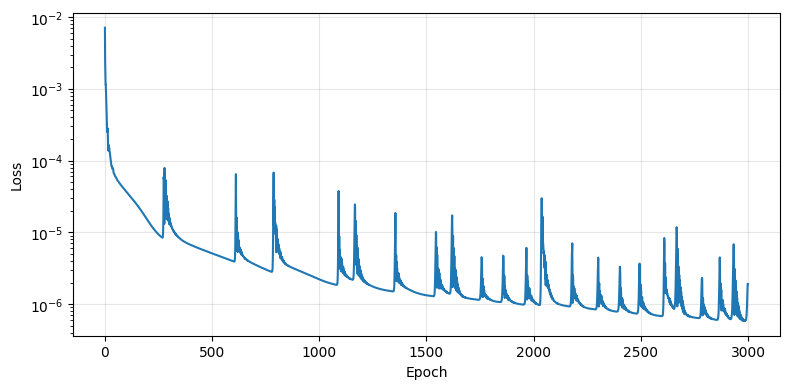

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figs/vanderpol_training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

## Zero-Shot Transfer: Test on Unseen $\mu$ Values

Now we test whether the learned basis functions can represent dynamics for **unseen** $\mu$ values.

Given a new $\mu$, we:
1. Generate a short trajectory (few steps)
2. Compute coefficients $\alpha$ via least squares
3. Use $\sum_i \alpha_i g_i(x)$ to predict long-term behavior

In [8]:
def predict_with_encoder(basis_fns, coeffs, x0, t_span, n_points=200):
    """Predict trajectory using function encoder"""
    t = torch.linspace(t_span[0], t_span[1], n_points).to(device)
    xs = torch.zeros(n_points, 2).to(device)
    xs[0] = x0
    
    def f_encoder(x):
        out = torch.zeros_like(x)
        for i, basis_fn in enumerate(basis_fns):
            out += coeffs[:, i] * basis_fn(x)
        return out
    
    for i in range(n_points - 1):
        dt = t[i+1] - t[i]
        xs[i+1] = rk4_step(f_encoder, xs[i], dt)
    
    return t, xs

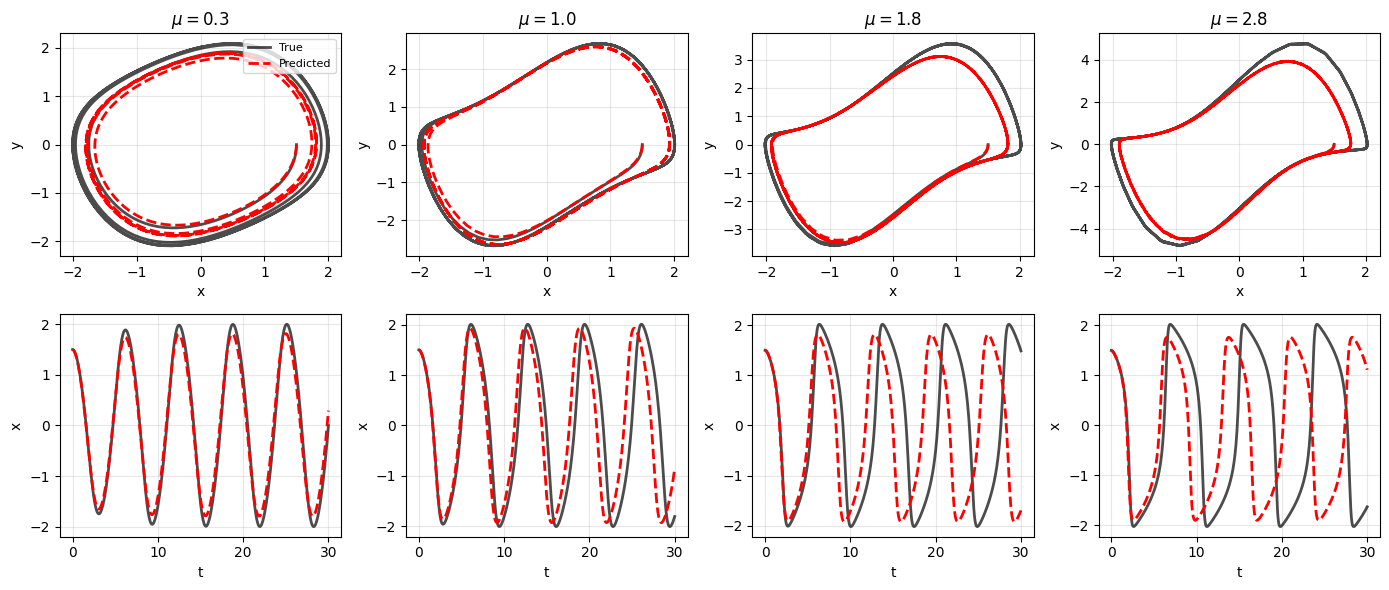

In [9]:
# Test on unseen mu values
mus_test = [0.3, 1.0, 1.8, 2.8]
x0_test = torch.tensor([1.5, 0.0]).to(device)

fig, axes = plt.subplots(2, 4, figsize=(14, 6))

with torch.no_grad():
    for i, mu in enumerate(mus_test):
        # Generate short trajectory for computing coefficients
        t_short, xs_short = generate_trajectory(mu, x0_test, [0, 5], n_points=100)
        dt_short = t_short[1:] - t_short[:-1]
        
        # Compute coefficients via least squares
        coeffs = compute_coefficients_ls(basis_functions, xs_short, dt_short)
        
        # Predict long trajectory
        t_pred, xs_pred = predict_with_encoder(basis_functions, coeffs, x0_test, [0, 30], n_points=500)
        
        # Ground truth
        t_true, xs_true = generate_trajectory(mu, x0_test, [0, 30], n_points=500)
        
        # Plot phase portrait
        axes[0, i].plot(xs_true.cpu().numpy()[:, 0], xs_true.cpu().numpy()[:, 1], 
                       'k-', linewidth=2, label='True', alpha=0.7)
        axes[0, i].plot(xs_pred.cpu().numpy()[:, 0], xs_pred.cpu().numpy()[:, 1], 
                       'r--', linewidth=2, label='Predicted')
        axes[0, i].set_xlabel('x')
        axes[0, i].set_ylabel('y')
        axes[0, i].set_title(f'$\\mu = {mu}$')
        axes[0, i].grid(True, alpha=0.3)
        if i == 0:
            axes[0, i].legend(loc='upper right', fontsize=8)
        
        # Plot time series
        axes[1, i].plot(t_true.cpu().numpy(), xs_true.cpu().numpy()[:, 0], 'k-', linewidth=2, alpha=0.7)
        axes[1, i].plot(t_pred.cpu().numpy(), xs_pred.cpu().numpy()[:, 0], 'r--', linewidth=2)
        axes[1, i].set_xlabel('t')
        axes[1, i].set_ylabel('x')
        axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/vanderpol_zero_shot.png', dpi=150, bbox_inches='tight')
plt.show()

## Quantitative Evaluation

We measure prediction error across different $\mu$ values:

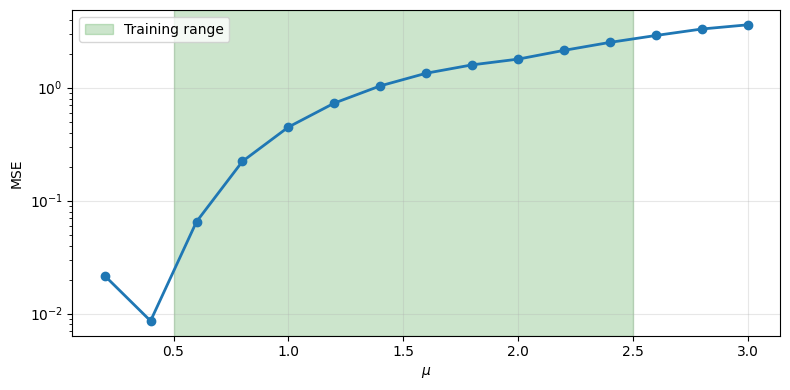

Mean error in training range: 1.186541
Mean error outside training range: 1.963793


In [10]:
# Evaluate on a range of mu values
mus_eval = torch.linspace(0.2, 3.0, 15)
errors = []

with torch.no_grad():
    for mu in mus_eval:
        x0 = torch.tensor([1.0, 0.0]).to(device)
        
        # Short trajectory for coefficient estimation
        t_short, xs_short = generate_trajectory(mu, x0, [0, 5], n_points=100)
        dt_short = t_short[1:] - t_short[:-1]
        coeffs = compute_coefficients_ls(basis_functions, xs_short, dt_short)
        
        # Long trajectory prediction
        t_pred, xs_pred = predict_with_encoder(basis_functions, coeffs, x0, [0, 20], n_points=400)
        t_true, xs_true = generate_trajectory(mu, x0, [0, 20], n_points=400)
        
        # Compute MSE
        mse = torch.mean((xs_pred - xs_true)**2).item()
        errors.append(mse)

# Plot error vs mu
plt.figure(figsize=(8, 4))
plt.plot(mus_eval.numpy(), errors, 'o-', linewidth=2, markersize=6)
plt.axvspan(mu_range[0], mu_range[1], alpha=0.2, color='green', label='Training range')
plt.xlabel('$\\mu$')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figs/vanderpol_error_vs_mu.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Mean error in training range: {np.mean([e for e, m in zip(errors, mus_eval) if mu_range[0] <= m <= mu_range[1]]):.6f}")
print(f"Mean error outside training range: {np.mean([e for e, m in zip(errors, mus_eval) if m < mu_range[0] or m > mu_range[1]]):.6f}")

## Comparison: Vanilla Neural ODE

For comparison, let's train a standard Neural ODE on the same data and evaluate its ability to transfer.

A vanilla Neural ODE learns a single function $f_\theta(x)$ without encoding $\mu$, so it cannot adapt to different parameter values.

In [11]:
class NeuralODE(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, x):
        return self.net(x)

# Train vanilla NODE
node = NeuralODE().to(device)
optimizer_node = torch.optim.Adam(node.parameters(), lr=1e-3)

print("Training vanilla Neural ODE...")
node_losses = []

for epoch in trange(n_epochs):
    optimizer_node.zero_grad()
    total_loss = 0
    
    for xs, t in zip(train_trajectories, train_times):
        dt = t[1:] - t[:-1]
        
        # Compute true derivatives
        dx_true = (xs[1:] - xs[:-1]) / dt.unsqueeze(-1)
        
        # Predict derivatives
        dx_pred = node(xs[:-1])
        
        loss = torch.mean((dx_true - dx_pred)**2)
        total_loss += loss
    
    total_loss.backward()
    optimizer_node.step()
    node_losses.append(total_loss.item())
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: loss={total_loss.item():.6f}")

print(f"Final loss: {node_losses[-1]:.6f}")

Training vanilla Neural ODE...


  3%|▎         | 78/3000 [00:00<00:03, 776.58it/s]

Epoch 0: loss=23.026798


 20%|██        | 613/3000 [00:00<00:03, 744.19it/s]

Epoch 500: loss=1.605445


 36%|███▋      | 1092/3000 [00:01<00:02, 753.13it/s]

Epoch 1000: loss=0.642482


 54%|█████▎    | 1609/3000 [00:02<00:01, 704.82it/s]

Epoch 1500: loss=0.432297


 70%|███████   | 2105/3000 [00:02<00:01, 674.89it/s]

Epoch 2000: loss=0.354308


 86%|████████▌ | 2587/3000 [00:03<00:00, 682.12it/s]

Epoch 2500: loss=0.314103


100%|██████████| 3000/3000 [00:04<00:00, 673.08it/s]

Final loss: 0.288834


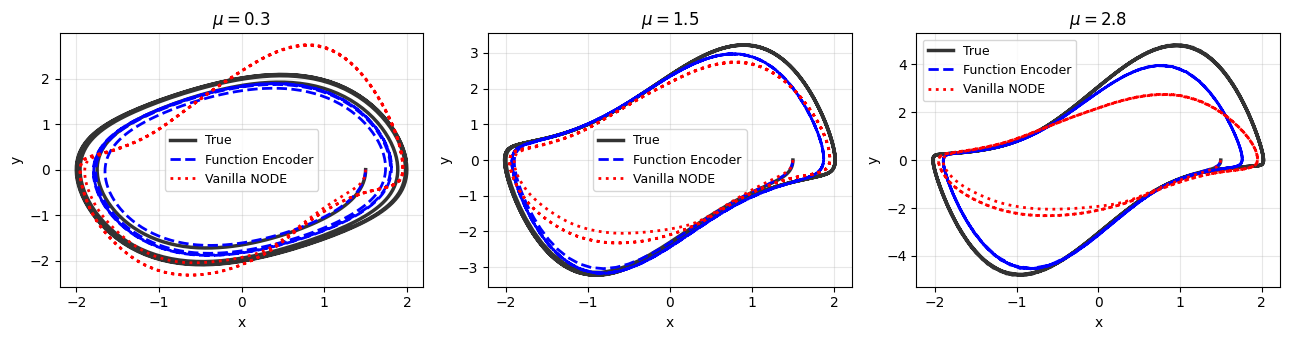

In [12]:
# Compare Function Encoder vs Vanilla NODE
mus_compare = [0.3, 1.5, 2.8]
x0_compare = torch.tensor([1.5, 0.0]).to(device)

fig, axes = plt.subplots(1, 3, figsize=(13, 3.5))

with torch.no_grad():
    for i, mu in enumerate(mus_compare):
        # Ground truth
        t_true, xs_true = generate_trajectory(mu, x0_compare, [0, 25], n_points=500)
        
        # Function Encoder prediction
        t_short, xs_short = generate_trajectory(mu, x0_compare, [0, 5], n_points=100)
        dt_short = t_short[1:] - t_short[:-1]
        coeffs = compute_coefficients_ls(basis_functions, xs_short, dt_short)
        t_fe, xs_fe = predict_with_encoder(basis_functions, coeffs, x0_compare, [0, 25], n_points=500)
        
        # Vanilla NODE prediction
        t_node = torch.linspace(0, 25, 500).to(device)
        xs_node = torch.zeros(500, 2).to(device)
        xs_node[0] = x0_compare
        for j in range(499):
            dt = t_node[j+1] - t_node[j]
            xs_node[j+1] = rk4_step(node, xs_node[j], dt)
        
        axes[i].plot(xs_true.cpu().numpy()[:, 0], xs_true.cpu().numpy()[:, 1], 
                    'k-', linewidth=2.5, label='True', alpha=0.8)
        axes[i].plot(xs_fe.cpu().numpy()[:, 0], xs_fe.cpu().numpy()[:, 1], 
                    'b--', linewidth=2, label='Function Encoder')
        axes[i].plot(xs_node.cpu().numpy()[:, 0], xs_node.cpu().numpy()[:, 1], 
                    'r:', linewidth=2, label='Vanilla NODE')
        
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
        axes[i].set_title(f'$\\mu = {mu}$')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('figs/vanderpol_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

**Function Encoder approach:**
- Learns basis functions that span the space of Van Der Pol dynamics
- Uses **least squares** to compute coefficients for each $\mu$ from trajectory data
- Enables **zero-shot transfer** to unseen $\mu$ values
- Only requires a short trajectory to adapt to new parameters

**Key advantage**: The vanilla Neural ODE learns an average dynamics, while the Function Encoder can quickly adapt to any $\mu$ by computing new coefficients via least squares—no retraining needed.